# Introduction

### Use Case
Building a machine learning model to accurately predict if patient have diabetes

### **Dataset details:**
- **Gender**: gender
- **Age**: age
- **Hypertension**: hypertension
- **Heart Disease**: heart_disease
- **Smoking History**: smoking_history
- **BMI**: bmi
- **Average Blood Glucose levels**: HbA1c_level
- **Blood Glucose Level**: blood_glucose_level
- **Outcome**: diabetes

# 1) Exploratory Data Analysis

In [36]:
#Installation of required libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report, balanced_accuracy_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import early_stopping
import warnings
import logging

warnings.simplefilter(action = "ignore") 
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("lightgbm").setLevel(logging.ERROR)


In [37]:
# Load the new dataset
csv_file_path = "diabetes_prediction_dataset.csv"
df = pd.read_csv(csv_file_path)

# Renaming columns to match the new dataset structure
df.rename(columns={
    'gender': 'Gender',
    'age': 'Age',
    'hypertension': 'Hypertension',
    'heart_disease': 'Heart_Disease',
    'smoking_history': 'Smoking_History',
    'bmi': 'BMI',
    'HbA1c_level': 'HbA1c_Level',
    'blood_glucose_level': 'Blood_Glucose_Level',
    'diabetes': 'Outcome'
}, inplace=True)

# Display basic info
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               100000 non-null  object 
 1   Age                  100000 non-null  float64
 2   Hypertension         100000 non-null  int64  
 3   Heart_Disease        100000 non-null  int64  
 4   Smoking_History      100000 non-null  object 
 5   BMI                  100000 non-null  float64
 6   HbA1c_Level          100000 non-null  float64
 7   Blood_Glucose_Level  100000 non-null  int64  
 8   Outcome              100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


,Gender,Age,Hypertension,Heart_Disease,Smoking_History,BMI,HbA1c_Level,Blood_Glucose_Level,Outcome
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
# The first 5 observation units of the data set were accessed.
df.head()

,Gender,Age,Hypertension,Heart_Disease,Smoking_History,BMI,HbA1c_Level,Blood_Glucose_Level,Outcome
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
# The size of the data set was examined. It consists of 768 observation units and 9 variables.
df.shape

(100000, 9)

In [5]:
#Feature information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               100000 non-null  object 
 1   Age                  100000 non-null  float64
 2   Hypertension         100000 non-null  int64  
 3   Heart_Disease        100000 non-null  int64  
 4   Smoking_History      100000 non-null  object 
 5   BMI                  100000 non-null  float64
 6   HbA1c_Level          100000 non-null  float64
 7   Blood_Glucose_Level  100000 non-null  int64  
 8   Outcome              100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
# Descriptive statistics of the data set accessed.
df.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
Age,100000.0,41.885856,22.516840,0.08,10.00,24.00,43.00,60.00,73.00,80.00,80.0000,80.00
Hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.0000,1.00
Heart_Disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0000,1.00
BMI,100000.0,27.320767,6.636783,10.01,19.18,23.63,27.32,29.58,35.47,39.49,48.7901,95.69
HbA1c_Level,100000.0,5.527507,1.070672,3.50,4.00,4.80,5.80,6.20,6.60,6.60,8.8000,9.00
Blood_Glucose_Level,100000.0,138.058060,40.708136,80.00,85.00,100.00,140.00,159.00,200.00,200.00,280.0000,300.00
Outcome,100000.0,0.085000,0.278883,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.0000,1.00


In [7]:
# The distribution of the Outcome variable was examined.
df["Outcome"].value_counts()*100/len(df)

Outcome
0    91.5
1     8.5
Name: count, dtype: float64

In [8]:
# The classes of the outcome variable were examined.
df.Outcome.value_counts()

Outcome
0    91500
1     8500
Name: count, dtype: int64

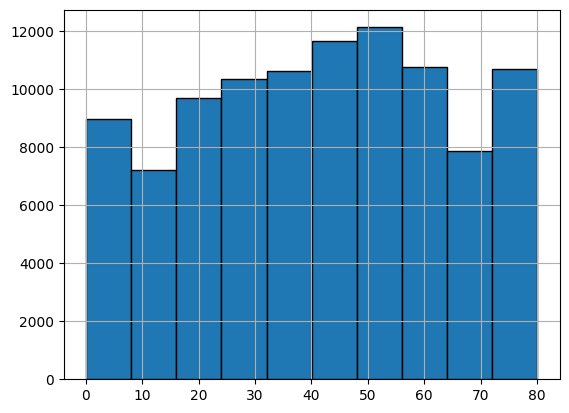

In [9]:
# The histagram of the Age variable was reached.
df["Age"].hist(edgecolor = "black");

In [10]:
print("Max Age: " + str(df["Age"].max()) + " Min Age: " + str(df["Age"].min()))

Max Age: 80.0 Min Age: 0.08


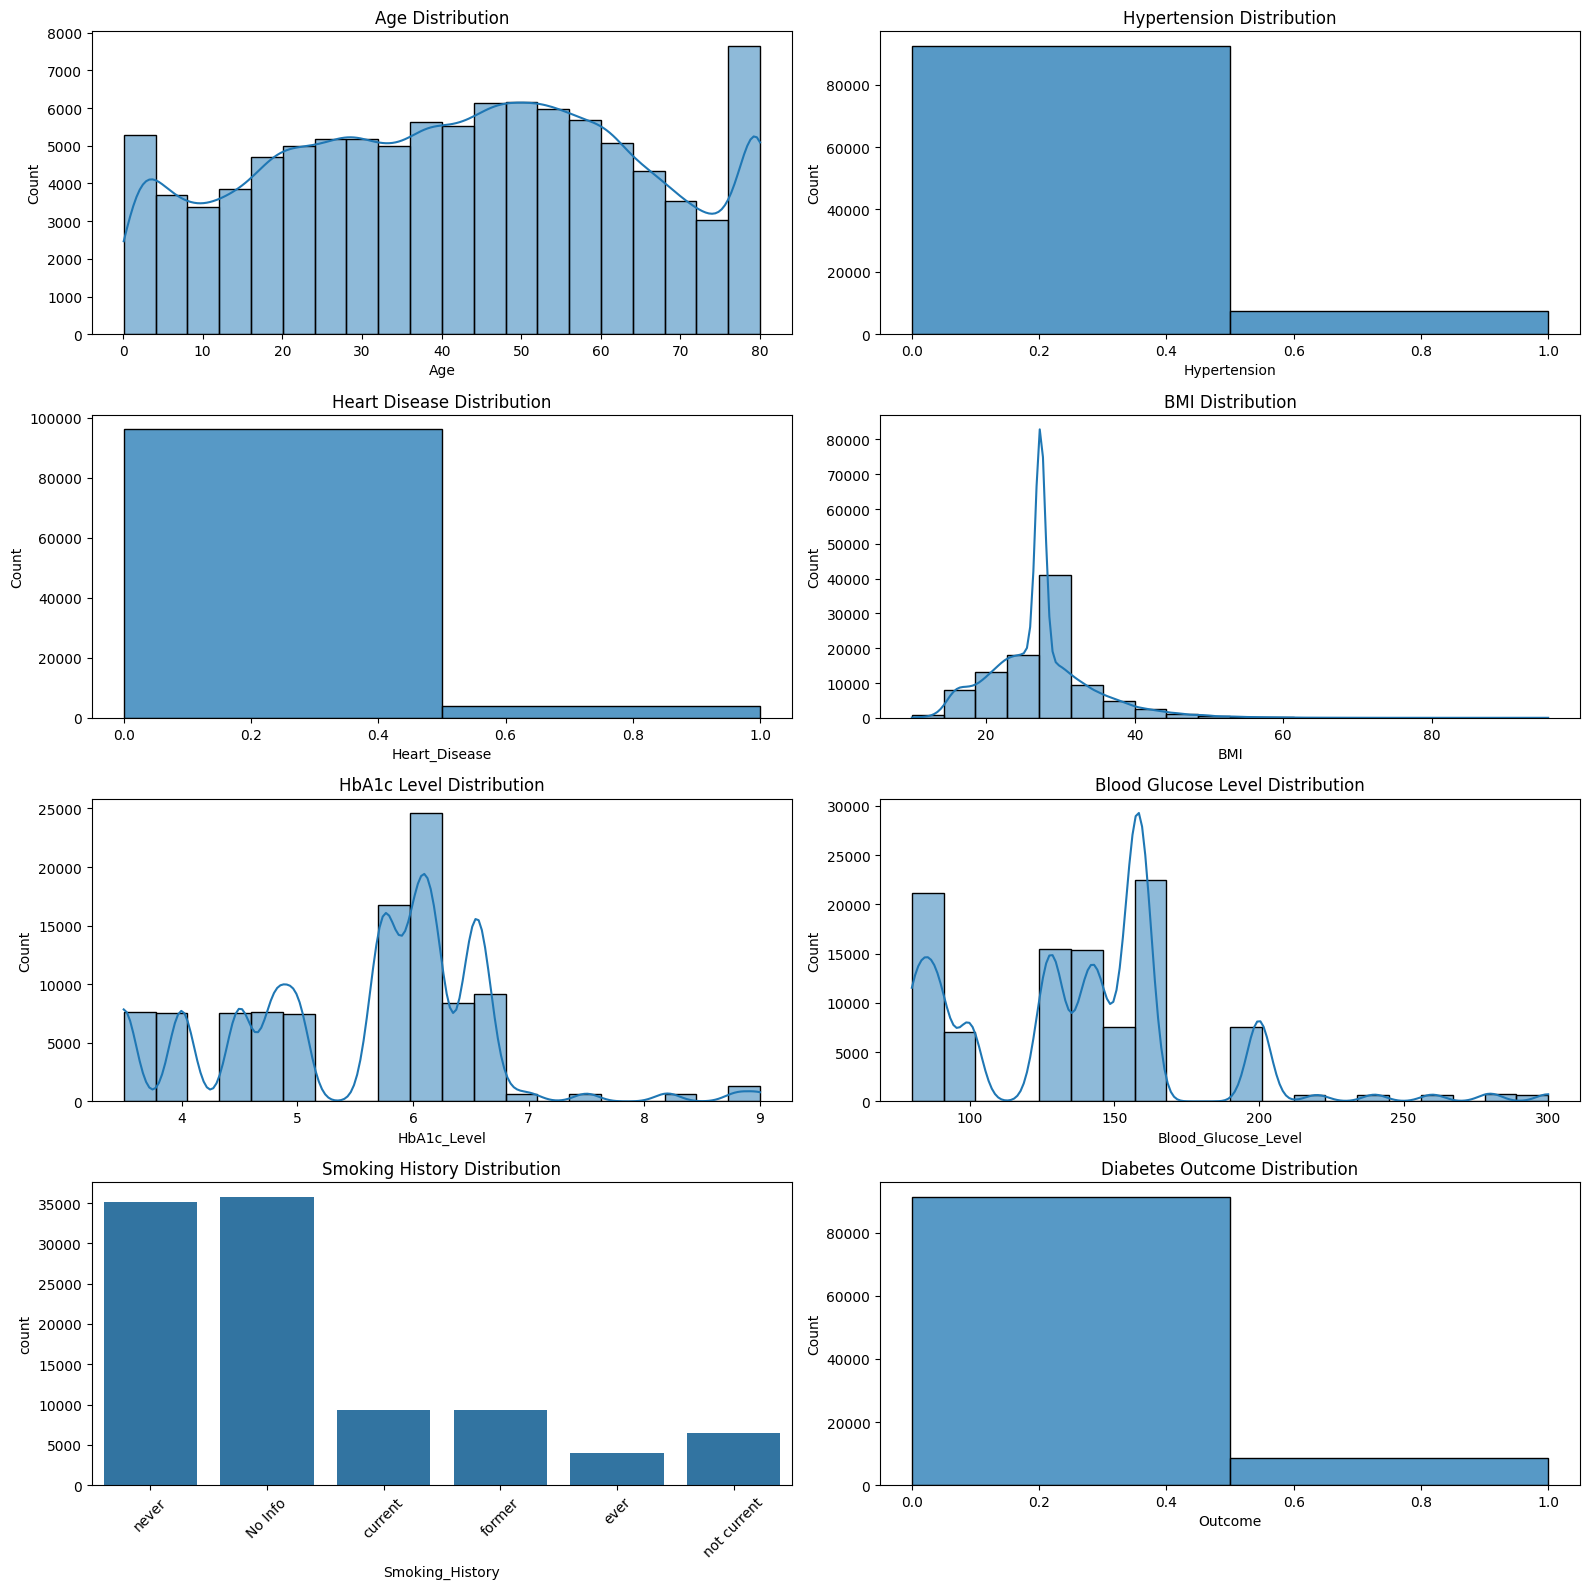

In [11]:
# Histogram and density graphs of all variables were accessed.
fig, ax = plt.subplots(4,2, figsize=(16,16))
sns.histplot(df.Age, bins=20, kde=True, ax=ax[0, 0])
ax[0, 0].set_title("Age Distribution")

sns.histplot(df.Hypertension, bins=2, kde=False, ax=ax[0, 1])
ax[0, 1].set_title("Hypertension Distribution")

sns.histplot(df.Heart_Disease, bins=2, kde=False, ax=ax[1, 0])
ax[1, 0].set_title("Heart Disease Distribution")

sns.histplot(df.BMI, bins=20, kde=True, ax=ax[1, 1])
ax[1, 1].set_title("BMI Distribution")

sns.histplot(df.HbA1c_Level, bins=20, kde=True, ax=ax[2, 0])
ax[2, 0].set_title("HbA1c Level Distribution")

sns.histplot(df.Blood_Glucose_Level, bins=20, kde=True, ax=ax[2, 1])
ax[2, 1].set_title("Blood Glucose Level Distribution")

sns.countplot(x=df.Smoking_History, ax=ax[3, 0])
ax[3, 0].set_title("Smoking History Distribution")
ax[3, 0].set_xticklabels(ax[3, 0].get_xticklabels(), rotation=45)

sns.histplot(df.Outcome, bins=2, kde=False, ax=ax[3, 1])
ax[3, 1].set_title("Diabetes Outcome Distribution")

plt.tight_layout()
plt.show()

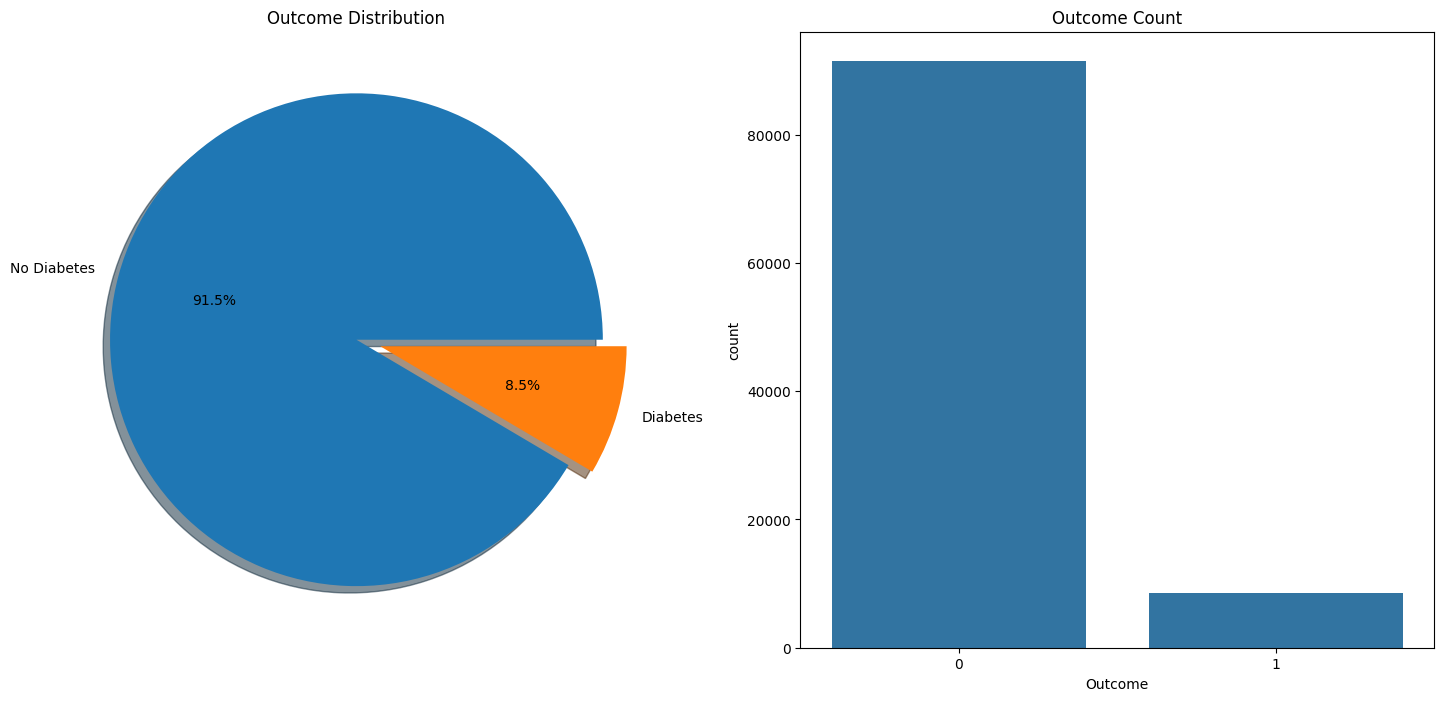

In [12]:
# The distribution of the outcome variable in the data was examined and visualized.
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Outcome'].value_counts().plot.pie(
    explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True, labels=['No Diabetes', 'Diabetes']
)
ax[0].set_title('Outcome Distribution')
ax[0].set_ylabel('')
sns.countplot(x='Outcome', data=df, ax=ax[1])  # Corrected the x argument
ax[1].set_title('Outcome Count')

plt.show()

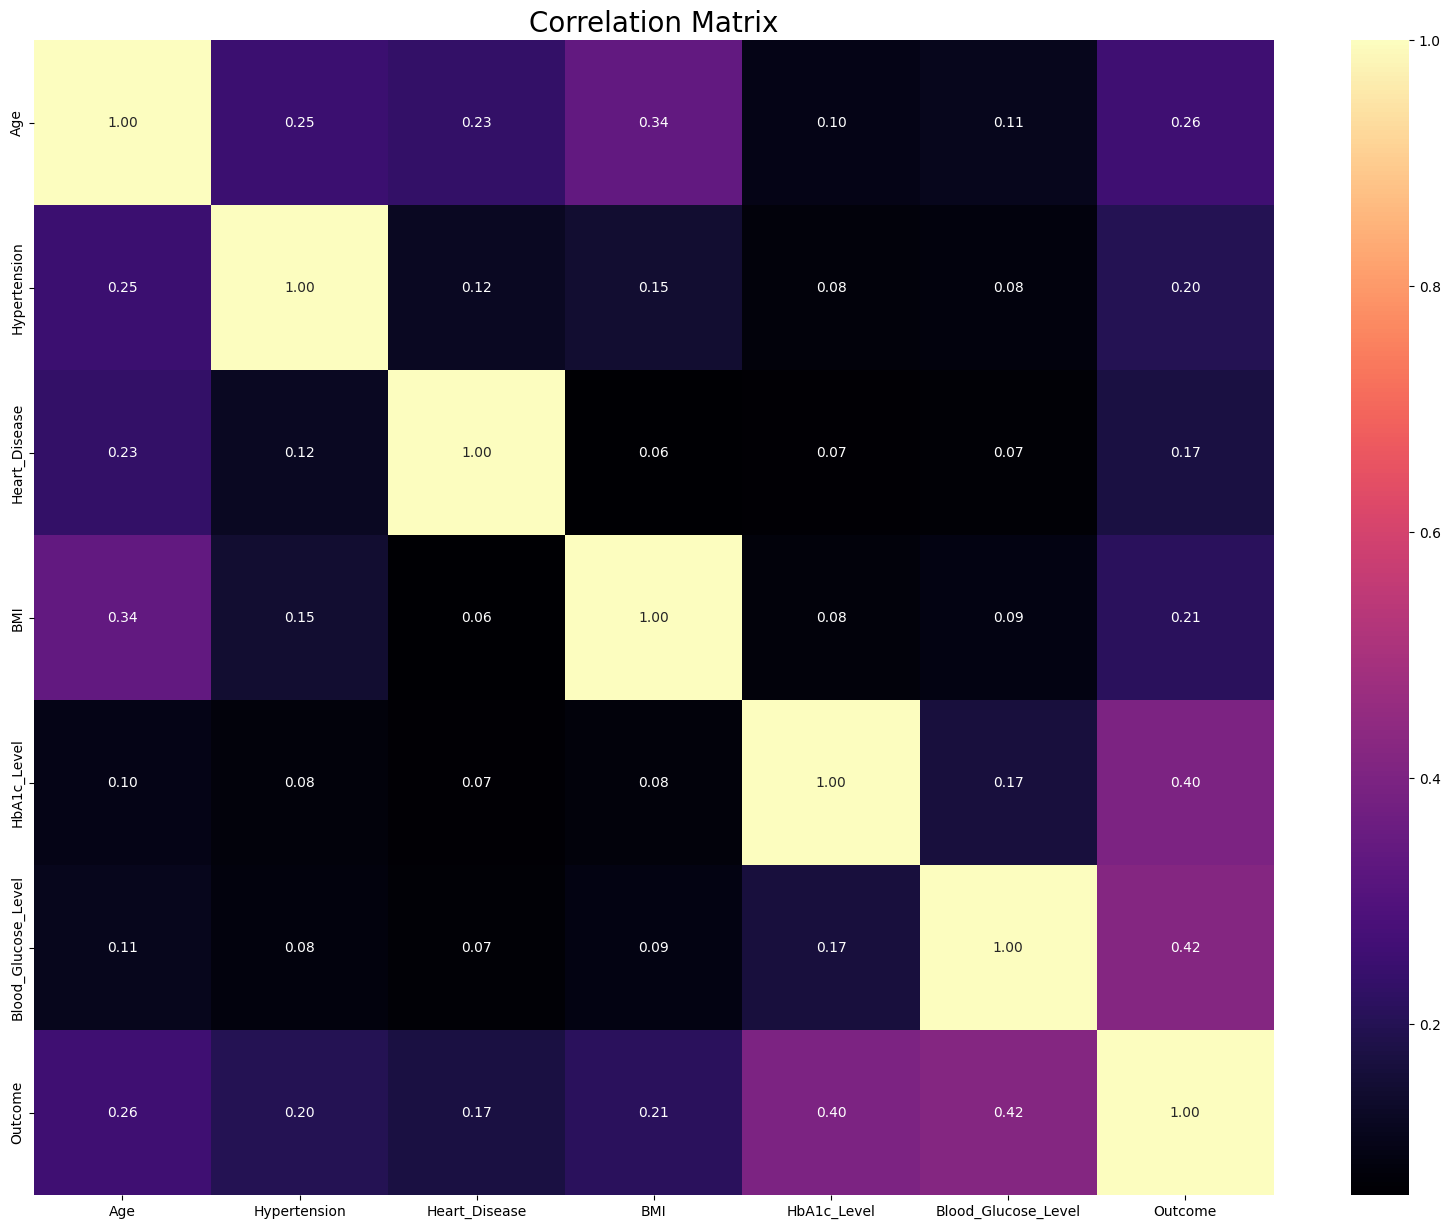

In [13]:
# Correlation matrix graph of the data set
# Select only numerical columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Correlation matrix heatmap
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)

plt.show()

# 2) Data Preprocessing

## 2.1) Missing Observation Analysis

We notice that some features contain 0, it doesn't make sense here and this indicates missing value Below we replace 0 value by NaN:

In [38]:
df[['BMI', 'Blood_Glucose_Level', 'HbA1c_Level']] = df[['BMI', 'Blood_Glucose_Level', 'HbA1c_Level']].replace(0, np.nan)
# Check for missing values
df.isnull().sum()

Gender                 0
Age                    0
Hypertension           0
Heart_Disease          0
Smoking_History        0
BMI                    0
HbA1c_Level            0
Blood_Glucose_Level    0
Outcome                0
dtype: int64

## 2.2) Outlier Observation Analysis

BMI yes (Outliers detected)
HbA1c_Level yes (Outliers detected)
Blood_Glucose_Level yes (Outliers detected)


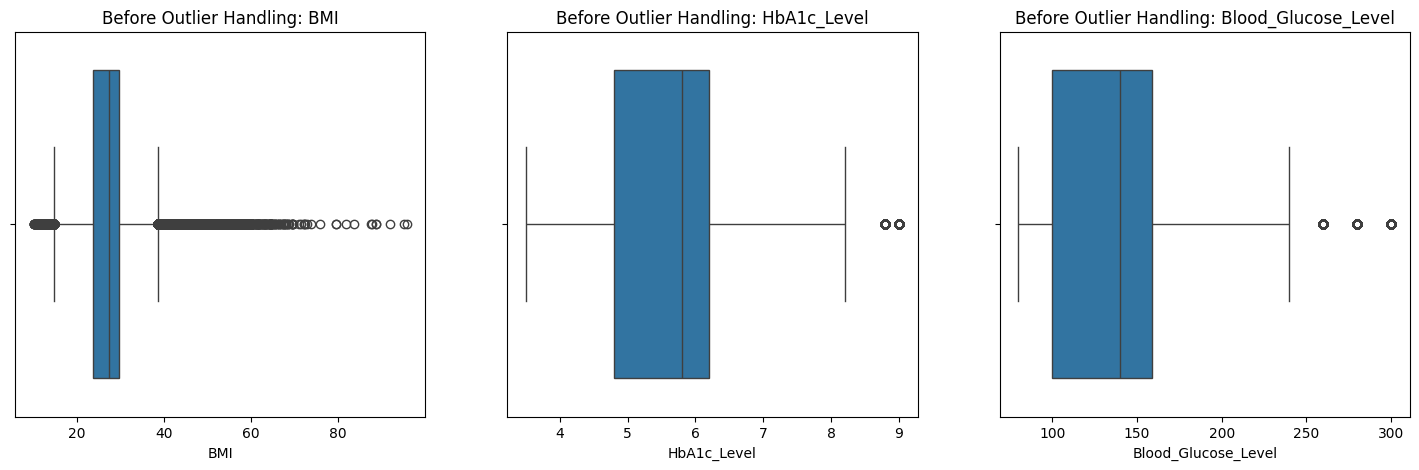

In [39]:
# In the data set, there were asked whether there were any outlier observations compared to the 25% and 75% quarters.
# List of features to check for outliers
features_to_check = ['BMI', 'HbA1c_Level', 'Blood_Glucose_Level']
for feature in features_to_check:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Check if any values exceed the upper bound (outliers)
    if (df[feature] > upper).any() or (df[feature] < lower).any():
        print(feature, "yes (Outliers detected)")
    else:
        print(feature, "no (No outliers)")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, feature in enumerate(features_to_check):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f"Before Outlier Handling: {feature}")
plt.show()

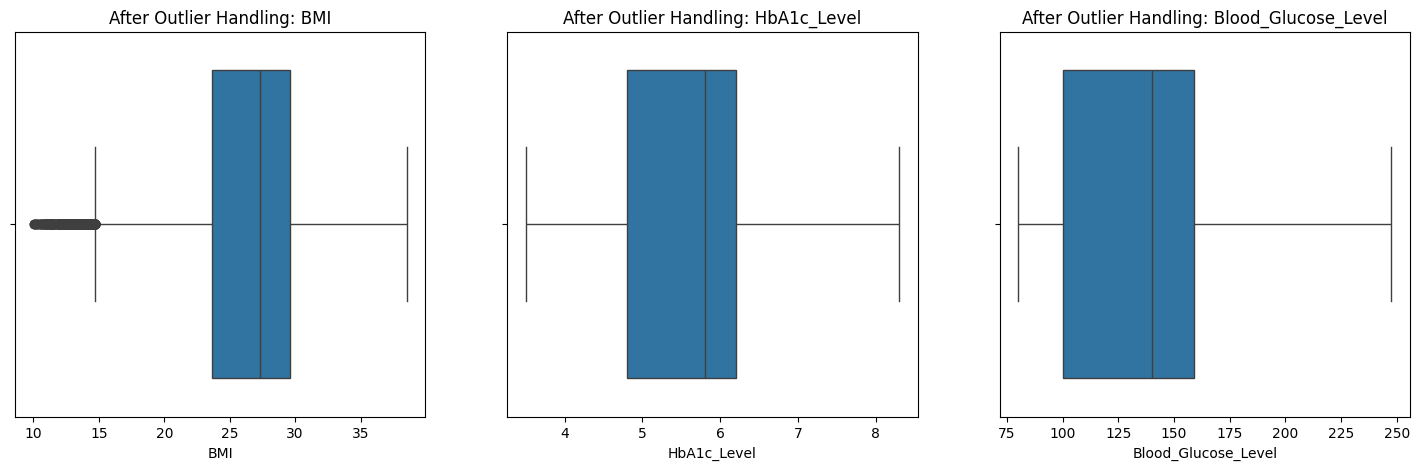

In [40]:
for feature in features_to_check:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR  # We only cap upper outliers
    
    # Replace values above the upper bound with the upper bound
    df.loc[df[feature] > upper, feature] = upper

# Plot after handling outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, feature in enumerate(features_to_check):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f"After Outlier Handling: {feature}")
plt.show()

# 3) Feature Engineering

Creating new variables is important for models. But you need to create a logical new variable. For this data set, some new variables were created according to BMI, Insulin and glucose variables.

In [41]:
df_fe = df.copy()

# 1️⃣ **BMI Categorical Mapping**
df_fe["NewBMI"] = "NaN"
df_fe.loc[df_fe["BMI"] < 18.5, "NewBMI"] = "Underweight"
df_fe.loc[(df_fe["BMI"] >= 18.5) & (df_fe["BMI"] <= 24.9), "NewBMI"] = "Normal"
df_fe.loc[(df_fe["BMI"] > 24.9) & (df_fe["BMI"] <= 29.9), "NewBMI"] = "Overweight"
df_fe.loc[(df_fe["BMI"] > 29.9) & (df_fe["BMI"] <= 34.9), "NewBMI"] = "Obesity 1"
df_fe.loc[(df_fe["BMI"] > 34.9) & (df_fe["BMI"] <= 39.9), "NewBMI"] = "Obesity 2"
df_fe.loc[df_fe["BMI"] > 39.9, "NewBMI"] = "Obesity 3"

# 2️⃣ **HbA1c Level Categorical Mapping**
df_fe["NewHbA1cLevel"] = "NaN"
df_fe.loc[df_fe["HbA1c_Level"] < 5.7, "NewHbA1cLevel"] = "Normal"
df_fe.loc[(df_fe["HbA1c_Level"] >= 5.7) & (df_fe["HbA1c_Level"] < 6.5), "NewHbA1cLevel"] = "Prediabetic"
df_fe.loc[df_fe["HbA1c_Level"] >= 6.5, "NewHbA1cLevel"] = "Diabetic"

# 3️⃣ **Blood Glucose Level Categorical Mapping**
df_fe["NewGlucose"] = "NaN"
df_fe.loc[df_fe["Blood_Glucose_Level"] <= 70, "NewGlucose"] = "Low"
df_fe.loc[(df_fe["Blood_Glucose_Level"] > 70) & (df_fe["Blood_Glucose_Level"] <= 99), "NewGlucose"] = "Normal"
df_fe.loc[(df_fe["Blood_Glucose_Level"] > 99) & (df_fe["Blood_Glucose_Level"] <= 126), "NewGlucose"] = "Prediabetic"
df_fe.loc[df_fe["Blood_Glucose_Level"] > 126, "NewGlucose"] = "Diabetic"

# Convert new categorical columns into category type
df_fe["NewBMI"] = df_fe["NewBMI"].astype("category")
df_fe["NewHbA1cLevel"] = df_fe["NewHbA1cLevel"].astype("category")
df_fe["NewGlucose"] = df_fe["NewGlucose"].astype("category")

# Display first few rows
df_fe.head()
print(df_fe.columns)


Index(['Gender', 'Age', 'Hypertension', 'Heart_Disease', 'Smoking_History',
       'BMI', 'HbA1c_Level', 'Blood_Glucose_Level', 'Outcome', 'NewBMI',
       'NewHbA1cLevel', 'NewGlucose'],
      dtype='object')


Testing Interaction features 

In [42]:
# Comorbidity Score: Combining hypertension and heart disease
df_fe["Comorbidity_Score"] = df_fe["Hypertension"] + df_fe["Heart_Disease"]

# BMI-to-Age Ratio
# df_fe["Bmi_Age_Ratio"] = df_fe["BMI"] / df_fe["Age"]

# Glucose Control Index (HbA1c * Blood Glucose Level)
df_fe["Glucose_Control_Index"] = df_fe["HbA1c_Level"] * df_fe["Blood_Glucose_Level"]

# Display first few rows
df_fe.head()

,Gender,Age,Hypertension,Heart_Disease,Smoking_History,BMI,HbA1c_Level,Blood_Glucose_Level,Outcome,NewBMI,NewHbA1cLevel,NewGlucose,Comorbidity_Score,Glucose_Control_Index
0,Female,80.0,0,1,never,25.19,6.6,140.0,0,Overweight,Diabetic,Diabetic,1,924.0
1,Female,54.0,0,0,No Info,27.32,6.6,80.0,0,Overweight,Diabetic,Normal,0,528.0
2,Male,28.0,0,0,never,27.32,5.7,158.0,0,Overweight,Prediabetic,Diabetic,0,900.6
3,Female,36.0,0,0,current,23.45,5.0,155.0,0,Normal,Normal,Diabetic,0,775.0
4,Male,76.0,1,1,current,20.14,4.8,155.0,0,Normal,Normal,Diabetic,2,744.0


# 4) One Hot Encoding

Categorical variables in the data set should be converted into numerical values. For this reason, these transformation processes are performed with Label Encoding and One Hot Encoding method.

In [43]:
categorical_columns = ["NewBMI", "NewHbA1cLevel", "NewGlucose", "Smoking_History"]
columns_to_encode = [col for col in categorical_columns if col in df_fe.columns]

df_fe = pd.get_dummies(df_fe, columns = categorical_columns, drop_first = True)

df_fe["Gender"] = LabelEncoder().fit_transform(df["Gender"]) # Encode Gender (Binary: Male=1, Female=0)

df_fe = df_fe.astype(int)
df_fe.head()


,Gender,Age,Hypertension,Heart_Disease,BMI,HbA1c_Level,Blood_Glucose_Level,Outcome,Comorbidity_Score,Glucose_Control_Index,...,NewBMI_Underweight,NewHbA1cLevel_Normal,NewHbA1cLevel_Prediabetic,NewGlucose_Normal,NewGlucose_Prediabetic,Smoking_History_current,Smoking_History_ever,Smoking_History_former,Smoking_History_never,Smoking_History_not current
0,0,80,0,1,25,6,140,0,1,924,...,0,0,0,0,0,0,0,0,1,0
1,0,54,0,0,27,6,80,0,0,528,...,0,0,0,1,0,0,0,0,0,0
2,1,28,0,0,27,5,158,0,0,900,...,0,0,1,0,0,0,0,0,1,0
3,0,36,0,0,23,5,155,0,0,775,...,0,1,0,0,0,1,0,0,0,0
4,1,76,1,1,20,4,155,0,2,744,...,0,1,0,0,0,1,0,0,0,0


Testing polynomial features 

In [44]:
# Select features for polynomial transformation
poly_features = ["Age", "HbA1c_Level", "Blood_Glucose_Level"]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Transform data
poly_transformed = poly.fit_transform(df_fe[poly_features])

# Convert to DataFrame and rename columns
poly_columns = poly.get_feature_names_out(poly_features)
df_poly = pd.DataFrame(poly_transformed, columns=poly_columns, index=df_fe.index)
df_poly.drop(poly_features, axis=1, inplace=True)
# Concatenate with main dataframe
df = pd.concat([df_fe, df_poly], axis=1)

# Display first few rows
df.head()

,Gender,Age,Hypertension,Heart_Disease,BMI,HbA1c_Level,Blood_Glucose_Level,Outcome,Comorbidity_Score,Glucose_Control_Index,...,NewGlucose_Normal,NewGlucose_Prediabetic,Smoking_History_current,Smoking_History_ever,Smoking_History_former,Smoking_History_never,Smoking_History_not current,Age HbA1c_Level,Age Blood_Glucose_Level,HbA1c_Level Blood_Glucose_Level
0,0,80,0,1,25,6,140,0,1,924,...,0,0,0,0,0,1,0,480.0,11200.0,840.0
1,0,54,0,0,27,6,80,0,0,528,...,1,0,0,0,0,0,0,324.0,4320.0,480.0
2,1,28,0,0,27,5,158,0,0,900,...,0,0,0,0,0,1,0,140.0,4424.0,790.0
3,0,36,0,0,23,5,155,0,0,775,...,0,0,1,0,0,0,0,180.0,5580.0,775.0
4,1,76,1,1,20,4,155,0,2,744,...,0,0,1,0,0,0,0,304.0,11780.0,620.0


In [45]:
print(df.columns)

Index(['Gender', 'Age', 'Hypertension', 'Heart_Disease', 'BMI', 'HbA1c_Level',
       'Blood_Glucose_Level', 'Outcome', 'Comorbidity_Score',
       'Glucose_Control_Index', 'NewBMI_Obesity 1', 'NewBMI_Obesity 2',
       'NewBMI_Overweight', 'NewBMI_Underweight', 'NewHbA1cLevel_Normal',
       'NewHbA1cLevel_Prediabetic', 'NewGlucose_Normal',
       'NewGlucose_Prediabetic', 'Smoking_History_current',
       'Smoking_History_ever', 'Smoking_History_former',
       'Smoking_History_never', 'Smoking_History_not current',
       'Age HbA1c_Level', 'Age Blood_Glucose_Level',
       'HbA1c_Level Blood_Glucose_Level'],
      dtype='object')


In [46]:
# Define target variable y
y = df["Outcome"]

# Copy the dataframe to avoid modifying the original
df_copy = df.copy()

# Drop redundant columns to keep only encoded and numeric features
columns_to_drop1 = ['Age HbA1c_Level', 'Age Blood_Glucose_Level','HbA1c_Level Blood_Glucose_Level', 'Outcome']
df_encoded_features = df_copy.drop(columns=columns_to_drop1, axis=1)

columns_to_drop2 = ['Gender', 'Age', 'Hypertension', 'Heart_Disease', 'BMI', 
                    'HbA1c_Level', 'Blood_Glucose_Level', 'Outcome', 
                    'Comorbidity_Score', 'Glucose_Control_Index', 
                    'NewBMI_Obesity 1', 'NewBMI_Obesity 2', 'NewBMI_Overweight', 
                    'NewBMI_Underweight', 'NewHbA1cLevel_Normal', 
                    'NewHbA1cLevel_Prediabetic', 'NewGlucose_Normal', 
                    'NewGlucose_Prediabetic', 'Smoking_History_current', 
                    'Smoking_History_ever', 'Smoking_History_former', 
                    'Smoking_History_never', 'Smoking_History_not current']
df_numeric_features = df_copy.drop(columns=columns_to_drop2, axis=1)

# Combine the remaining feature columns correctly
X = df_copy[df_encoded_features.columns.union(df_numeric_features.columns)]

# Display first few rows
X.head()

,Age,Age Blood_Glucose_Level,Age HbA1c_Level,BMI,Blood_Glucose_Level,Comorbidity_Score,Gender,Glucose_Control_Index,HbA1c_Level,HbA1c_Level Blood_Glucose_Level,...,NewBMI_Underweight,NewGlucose_Normal,NewGlucose_Prediabetic,NewHbA1cLevel_Normal,NewHbA1cLevel_Prediabetic,Smoking_History_current,Smoking_History_ever,Smoking_History_former,Smoking_History_never,Smoking_History_not current
0,80,11200.0,480.0,25,140,1,0,924,6,840.0,...,0,0,0,0,0,0,0,0,1,0
1,54,4320.0,324.0,27,80,0,0,528,6,480.0,...,0,1,0,0,0,0,0,0,0,0
2,28,4424.0,140.0,27,158,0,1,900,5,790.0,...,0,0,0,0,1,0,0,0,1,0
3,36,5580.0,180.0,23,155,0,0,775,5,775.0,...,0,0,0,1,0,1,0,0,0,0
4,76,11780.0,304.0,20,155,2,1,744,4,620.0,...,0,0,0,1,0,1,0,0,0,0


In [47]:
# Apply RobustScaler
transformer = RobustScaler().fit(X)
X_scaled = transformer.transform(X)

# Convert back to DataFrame using updated column names
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X.head()

,Age,Age Blood_Glucose_Level,Age HbA1c_Level,BMI,Blood_Glucose_Level,Comorbidity_Score,Gender,Glucose_Control_Index,HbA1c_Level,HbA1c_Level Blood_Glucose_Level,...,NewBMI_Underweight,NewGlucose_Normal,NewGlucose_Prediabetic,NewHbA1cLevel_Normal,NewHbA1cLevel_Prediabetic,Smoking_History_current,Smoking_History_ever,Smoking_History_former,Smoking_History_never,Smoking_History_not current
0,1.027778,1.115970,1.403061,-0.333333,0.000000,1.0,0.0,0.474934,0.5,0.519126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.305556,-0.192015,0.607143,0.000000,-1.016949,0.0,0.0,-0.569921,0.5,-0.464481,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.416667,-0.172243,-0.331633,0.000000,0.305085,0.0,1.0,0.411609,0.0,0.382514,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.194444,0.047529,-0.127551,-0.666667,0.254237,0.0,0.0,0.081794,0.0,0.341530,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.916667,1.226236,0.505102,-1.166667,0.254237,2.0,1.0,0.000000,-0.5,-0.081967,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [48]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Outcome, dtype: int64

# 5) Splitting Data into 3 Sets (Train, Test, Dev)

Train set shape: (70000, 25), (70000,)
Development set shape: (15000, 25), (15000,)
Test set shape: (15000, 25), (15000,)


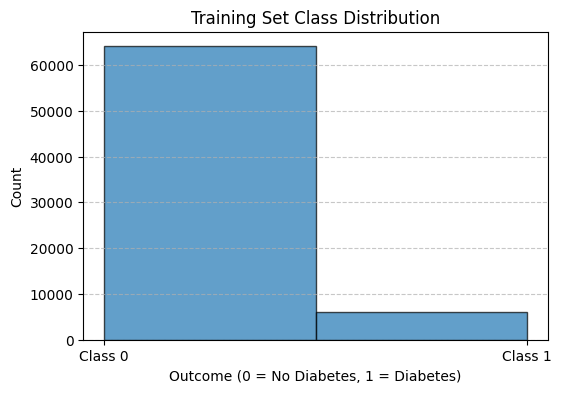

In [49]:
# First, split into training (70%) and remaining (30%)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Then, split the remaining into development (15%) and test (15%)
X_dev, X_test, y_dev, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

# Print dataset shapes
print(f"Train set shape: {X_train.shape}, {y_train.shape}")
print(f"Development set shape: {X_dev.shape}, {y_dev.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Plot Class Distribution Before SMOTE
def plot_class_distribution(y_data, title):
    plt.figure(figsize=(6,4))
    plt.hist(y_data, bins=2, edgecolor='black', alpha=0.7)
    plt.xticks([0,1], labels=['Class 0', 'Class 1'])
    plt.xlabel("Outcome (0 = No Diabetes, 1 = Diabetes)")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot BEFORE applying SMOTE
plot_class_distribution(y_train, "Training Set Class Distribution")


### With SMOTE + RUS

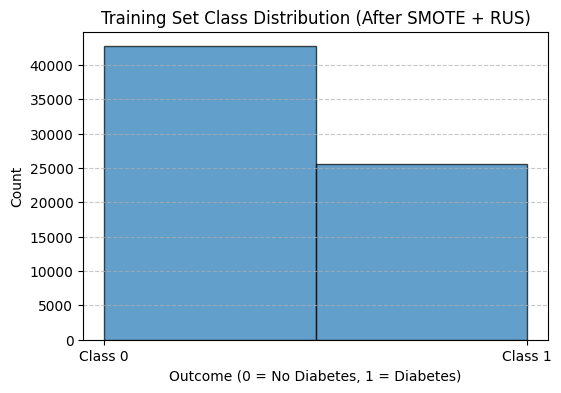

In [50]:
# Apply SMOTE + RUS Hybrid
smote = SMOTE(sampling_strategy=0.4, random_state=42)  # SMOTE first (40% minority cases)
rus = RandomUnderSampler(sampling_strategy=0.6, random_state=42)  # Then RUS (60% majority cases)

# Apply SMOTE first, then RUS
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_smote, y_train_smote)

# Plot AFTER applying SMOTE + RUS
plot_class_distribution(y_train_balanced, "Training Set Class Distribution (After SMOTE + RUS)")


# 6) Modelling

## 6.1) Before Hyperparameter Tuning

### Random Forest

In [51]:
# ✅ Step 1: Define Random Forest Model
rf_model = RandomForestClassifier()

# ✅ Step 2: Train Random Forest Model
rf_model.fit(X_train_balanced, y_train_balanced)

# ✅ Step 3: Make Predictions
y_pred_rf = rf_model.predict(X_test)

# ✅ Step 4: Compute Accuracy & Balanced Accuracy
test_accuracy_rf = accuracy_score(y_test, y_pred_rf) * 100
test_balanced_accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf) * 100

# ✅ Step 5: Print Scores
print("\nRandom Forest Model Performance")
print(f"Test Accuracy: {test_accuracy_rf:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy_rf:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Model Performance
Test Accuracy: 95.8200%
Test Balanced Accuracy: 85.7990%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     13725
           1       0.76      0.74      0.75      1275

    accuracy                           0.96     15000
   macro avg       0.87      0.86      0.86     15000
weighted avg       0.96      0.96      0.96     15000



### XGBoost

In [52]:
# ✅ Step 1: Define XGBoost Model
xgb_model = XGBClassifier()

# ✅ Step 2: Train XGBoost Model
xgb_model.fit(X_train_balanced, y_train_balanced)

# ✅ Step 3: Make Predictions
y_pred_xgb = xgb_model.predict(X_test)

# ✅ Step 4: Compute Accuracy & Balanced Accuracy
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb) * 100
test_balanced_accuracy_xgb = balanced_accuracy_score(y_test, y_pred_xgb) * 100

# ✅ Step 5: Print Scores
print("\nXGBoost Model Performance")
print(f"Test Accuracy: {test_accuracy_xgb:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy_xgb:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))



XGBoost Model Performance
Test Accuracy: 96.6800%
Test Balanced Accuracy: 85.9488%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     13725
           1       0.86      0.73      0.79      1275

    accuracy                           0.97     15000
   macro avg       0.92      0.86      0.89     15000
weighted avg       0.97      0.97      0.97     15000



### LightGBM

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0898239

Feature Importance AFTER Hyperparameter Tuning - XGBoost
                            Feature  Importance
9   HbA1c_Level Blood_Glucose_Level    0.384632
8                       HbA1c_Level    0.116634
18             NewHbA1cLevel_Normal    0.111290
2                   Age HbA1c_Level    0.089669
4               Blood_Glucose_Level    0.063704
7             Glucose_Control_Index    0.059940
3                               BMI    0.022188
5                 Comorbidity_Score    0.020622
17           NewGlucose_Prediabetic    0.014321
6                            Gender    0.014301


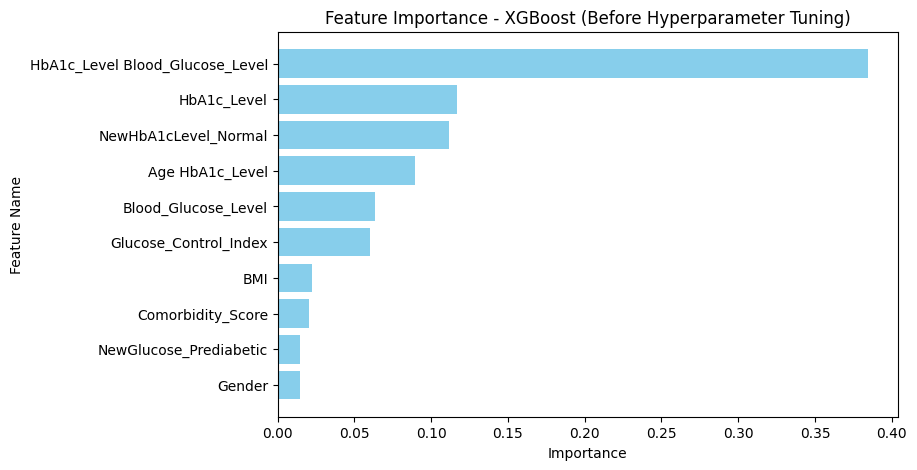


LightGBM Model Performance
Test Accuracy: 96.7800%
Test Balanced Accuracy: 86.3236%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     13725
           1       0.86      0.74      0.80      1275

    accuracy                           0.97     15000
   macro avg       0.92      0.86      0.89     15000
weighted avg       0.97      0.97      0.97     15000



In [53]:
# ✅ Step 1: Define LightGBM Model
lgb_model = lgb.LGBMClassifier(verbose=-1)

# ✅ Step 2: Train LightGBM with Early Stopping Using Callbacks
lgb_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_test, y_test)],  # Validation set
    eval_metric="logloss",
    callbacks=[early_stopping(10)]  # Stops after 10 rounds with no improvement
)

# ✅ Print Feature Importance AFTER Tuning (Corrected)
print("\nFeature Importance AFTER Hyperparameter Tuning - XGBoost")

# Ensure X_train_balanced is correctly referenced
feature_importance_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': xgb_model.feature_importances_})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print Top 10 Most Important Features
print(feature_importance_df.head(10))  # Print Top 10 Features

# Plot Feature Importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance - XGBoost (Before Hyperparameter Tuning)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# ✅ Step 3: Make Predictions
y_pred_lgb = lgb_model.predict(X_test)

# ✅ Step 4: Compute Accuracy & Balanced Accuracy
test_accuracy = accuracy_score(y_test, y_pred_lgb) * 100
test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_lgb) * 100

# ✅ Step 5: Print Scores
print("\nLightGBM Model Performance")
print(f"Test Accuracy: {test_accuracy:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))

### Logistic Regression with Feature Scaling

In [54]:
# ✅ Step 1: Define Logistic Regression Model with Feature Scaling
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression())
])

# ✅ Step 2: Train Logistic Regression Model
log_reg_pipeline.fit(X_train_balanced, y_train_balanced)

# ✅ Step 3: Make Predictions
y_pred_log_reg = log_reg_pipeline.predict(X_test)

# ✅ Step 4: Compute Accuracy & Balanced Accuracy
test_accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg) * 100
test_balanced_accuracy_log_reg = balanced_accuracy_score(y_test, y_pred_log_reg) * 100

# ✅ Step 5: Print Scores
print("\nLogistic Regression Model Performance")
print(f"Test Accuracy: {test_accuracy_log_reg:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy_log_reg:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_reg))


Logistic Regression Model Performance
Test Accuracy: 91.7800%
Test Balanced Accuracy: 88.3937%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     13725
           1       0.51      0.84      0.64      1275

    accuracy                           0.92     15000
   macro avg       0.75      0.88      0.79     15000
weighted avg       0.94      0.92      0.93     15000



### SVM with Feature Scaling

In [55]:
# ✅ Step 1: Define SVM Model with Feature Scaling
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel='rbf', probability=True, random_state=42))
])

# ✅ Step 2: Train SVM Model
svm_pipeline.fit(X_train_balanced, y_train_balanced)

# ✅ Step 3: Make Predictions
y_pred_svm = svm_pipeline.predict(X_test)

# ✅ Step 4: Compute Accuracy & Balanced Accuracy
test_accuracy_svm = accuracy_score(y_test, y_pred_svm) * 100
test_balanced_accuracy_svm = balanced_accuracy_score(y_test, y_pred_svm) * 100

# ✅ Step 5: Print Scores
print("\nSVM Model Performance")
print(f"Test Accuracy: {test_accuracy_svm:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy_svm:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))



SVM Model Performance
Test Accuracy: 93.2733%
Test Balanced Accuracy: 89.2097%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     13725
           1       0.57      0.84      0.68      1275

    accuracy                           0.93     15000
   macro avg       0.78      0.89      0.82     15000
weighted avg       0.95      0.93      0.94     15000



### Hybrid (XGBoost + LR)

In [56]:
# ✅ Step 1: Define XGBoost Model
xgb_model = XGBClassifier()

# ✅ Step 2: Train XGBoost Model
xgb_model.fit(X_train_balanced, y_train_balanced)

# ✅ Step 3: Extract XGBoost Predictions (Probability Scores)
y_train_xgb = xgb_model.predict_proba(X_train_balanced)[:, 1]
X_test_xgb = xgb_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

# ✅ Step 4: Standardize the Features (Needed for Logistic Regression)
scaler = StandardScaler()
y_train_xgb_scaled = scaler.fit_transform(y_train_xgb.reshape(-1, 1))
X_test_xgb_scaled = scaler.transform(X_test_xgb)

# ✅ Step 5: Train Logistic Regression on XGBoost Predictions
log_reg = LogisticRegression()
log_reg.fit(y_train_xgb_scaled, y_train_balanced)

# ✅ Step 6: Make Final Predictions Using Logistic Regression
y_pred_hybrid_log_reg = log_reg.predict(X_test_xgb_scaled)

# ✅ Step 7: Compute Accuracy & Balanced Accuracy
test_accuracy_hybrid = accuracy_score(y_test, y_pred_hybrid_log_reg) * 100
test_balanced_accuracy_hybrid = balanced_accuracy_score(y_test, y_pred_hybrid_log_reg) * 100

# ✅ Step 8: Print Scores
print("\nHybrid Model (XGBoost + Logistic Regression) Performance")
print(f"Test Accuracy: {test_accuracy_hybrid:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy_hybrid:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_hybrid_log_reg))


Hybrid Model (XGBoost + Logistic Regression) Performance
Test Accuracy: 96.2067%
Test Balanced Accuracy: 87.3265%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     13725
           1       0.78      0.77      0.77      1275

    accuracy                           0.96     15000
   macro avg       0.88      0.87      0.88     15000
weighted avg       0.96      0.96      0.96     15000



### Hybrid (XGBoost + SVM)

In [57]:
# ✅ Step 1: Define XGBoost Model
xgb_model = XGBClassifier()

# ✅ Step 2: Train XGBoost Model
xgb_model.fit(X_train_balanced, y_train_balanced)

# ✅ Step 3: Extract XGBoost Predictions (Probability Scores)
y_train_xgb = xgb_model.predict_proba(X_train_balanced)[:, 1]
X_test_xgb = xgb_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

# ✅ Step 4: Standardize the Features (Needed for SVM)
scaler = StandardScaler()
y_train_xgb_scaled = scaler.fit_transform(y_train_xgb.reshape(-1, 1))
X_test_xgb_scaled = scaler.transform(X_test_xgb)

# ✅ Step 5: Train SVM on XGBoost Predictions
# svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model = SVC()
svm_model.fit(y_train_xgb_scaled, y_train_balanced)

# ✅ Step 6: Make Final Predictions Using SVM
y_pred_hybrid_svm = svm_model.predict(X_test_xgb_scaled)

# ✅ Step 7: Compute Accuracy & Balanced Accuracy
test_accuracy_hybrid = accuracy_score(y_test, y_pred_hybrid_svm) * 100
test_balanced_accuracy_hybrid = balanced_accuracy_score(y_test, y_pred_hybrid_svm) * 100

# ✅ Step 8: Print Scores
print("\nHybrid Model (XGBoost + SVM) Performance")
print(f"Test Accuracy: {test_accuracy_hybrid:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy_hybrid:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_hybrid_svm))


Hybrid Model (XGBoost + SVM) Performance
Test Accuracy: 96.6133%
Test Balanced Accuracy: 86.4104%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     13725
           1       0.84      0.74      0.79      1275

    accuracy                           0.97     15000
   macro avg       0.91      0.86      0.88     15000
weighted avg       0.96      0.97      0.97     15000



### Model Performance Summary

In [58]:
# Define model names
model_names = [
    "Random Forest", "XGBoost", "LightGBM", "Logistic Regression", "SVM", "Hybrid (XGBoost + Logistic Regression)", "Hybrid (XGBoost + SVM)"
]

# Initialize lists for metrics
accuracy_values = []
balanced_accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Models and predictions dictionary
models_predictions = {
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "LightGBM": y_pred_lgb,
    "Logistic Regression": y_pred_log_reg,
    "SVM": y_pred_svm,
    "Hybrid (XGBoost + Logistic Regression)": y_pred_hybrid_log_reg,
    "Hybrid (XGBoost + SVM)": y_pred_hybrid_svm
}

# Collect performance metrics for each model
for model, y_pred in models_predictions.items():
    accuracy_values.append(accuracy_score(y_test, y_pred))
    balanced_accuracy_values.append(balanced_accuracy_score(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    precision_values.append(report['weighted avg']['precision'])
    recall_values.append(report['weighted avg']['recall'])
    f1_values.append(report['weighted avg']['f1-score'])

# Create DataFrame
results_df = pd.DataFrame({
    "Model": model_names,
    "Test Accuracy": accuracy_values,
    "Balanced Accuracy": balanced_accuracy_values,
    "Precision": precision_values,
    "Recall": recall_values,
    "F1-Score": f1_values
})

# Print the table
print("\nModel Performance Summary")
print(results_df.to_string(index=False))


Model Performance Summary
                                 Model  Test Accuracy  Balanced Accuracy  Precision   Recall  F1-Score
                         Random Forest       0.958200           0.857990   0.957590 0.958200  0.957874
                               XGBoost       0.966800           0.859488   0.965315 0.966800  0.965578
                              LightGBM       0.967800           0.863236   0.966404 0.967800  0.966635
                   Logistic Regression       0.917800           0.883937   0.944152 0.917800  0.926634
                                   SVM       0.932733           0.892097   0.949548 0.932733  0.938454
Hybrid (XGBoost + Logistic Regression)       0.962067           0.873265   0.961715 0.962067  0.961882
                Hybrid (XGBoost + SVM)       0.966133           0.864104   0.964768 0.966133  0.965153


### ROC Curves & Confusion Matrix Before Hypertuning

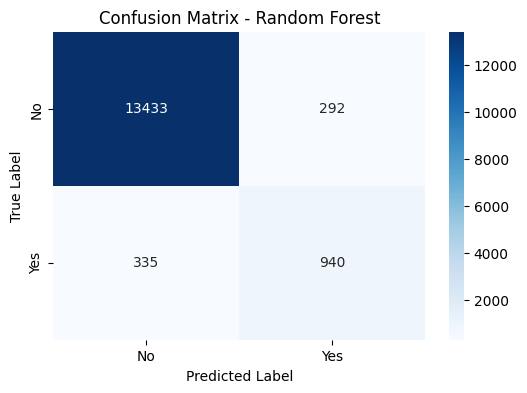

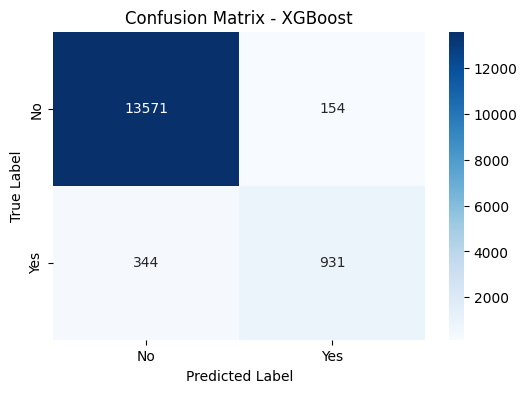

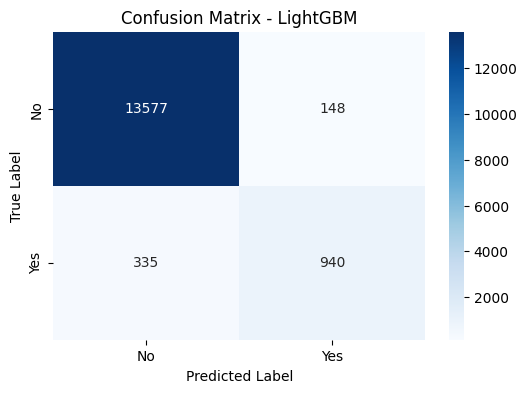

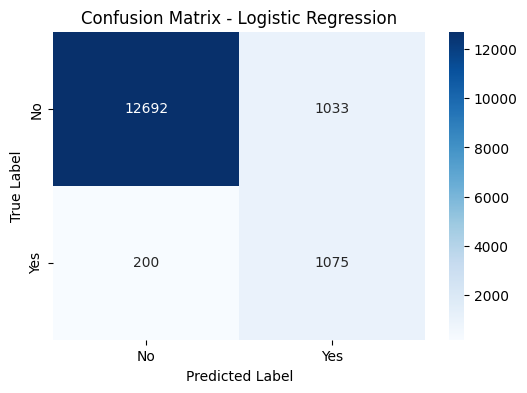

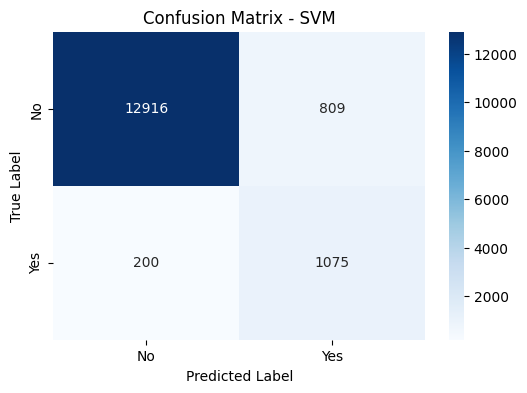

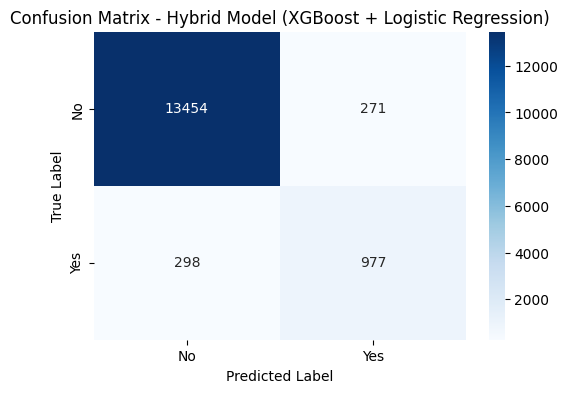

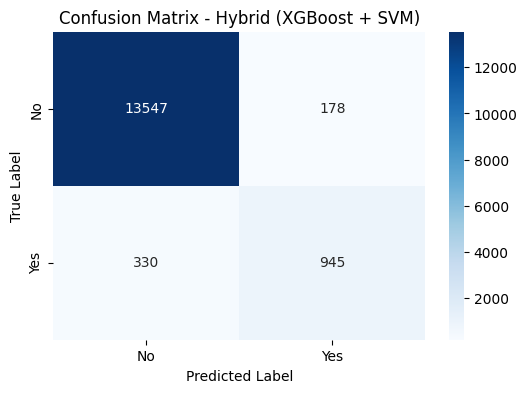

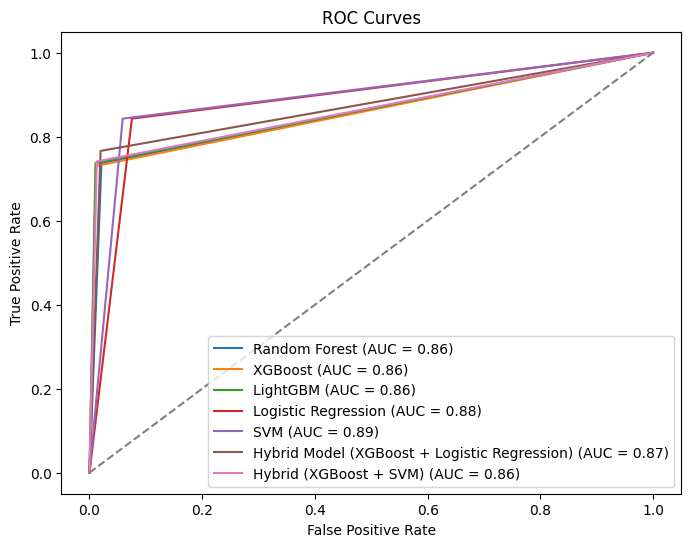

In [59]:
# ✅ Define model predictions dictionary
models = {
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "LightGBM": y_pred_lgb,
    "Logistic Regression": y_pred_log_reg,
    "SVM": y_pred_svm,
    "Hybrid Model (XGBoost + Logistic Regression)": y_pred_hybrid_log_reg,
    "Hybrid (XGBoost + SVM)": y_pred_hybrid_svm
}

# ✅ Confusion Matrices
for model_name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# ✅ ROC Curves
plt.figure(figsize=(8, 6))
for model_name, y_pred in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

## 6.2) After Hyperparameter Tuning

### LightGBM using GridSearchCV

Default (before parameters)

In [60]:
# Initialize LightGBM model (default)
lgbm_default = lgb.LGBMClassifier()

# Train the default model
lgbm_default.fit(X_train, y_train)
y_pred_lgbm_default = lgbm_default.predict(X_test)

# Evaluate performance of the default model
print("\n🚀 **Default LightGBM Model Performance** 🚀")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lgbm_default):.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_lgbm_default):.4f}")
print("\nClassification Report for Default Model:\n", classification_report(y_test, y_pred_lgbm_default))


🚀 **Default LightGBM Model Performance** 🚀
Test Accuracy: 0.9709
Test Balanced Accuracy: 0.8372

Classification Report for Default Model:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     13725
           1       0.97      0.68      0.80      1275

    accuracy                           0.97     15000
   macro avg       0.97      0.84      0.89     15000
weighted avg       0.97      0.97      0.97     15000



After Parameters

In [61]:
# Define LightGBM parameter grid
param_grid_lgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'num_leaves': [20, 31, 50],
    'scale_pos_weight': [1, 2]
}

# Initialize LightGBM model
lgbm = lgb.LGBMClassifier()

# Perform Grid Search for LightGBM
grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgb, scoring='balanced_accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search_lgbm.fit(X_train_balanced, y_train_balanced)
print("Best LightGBM Hyperparameters:", grid_search_lgbm.best_params_)

# Best LightGBM model
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_lgbm_opt = best_lgbm.predict(X_test)

# Evaluate performance
print("\n**Optimized LightGBM Model Performance**")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lgbm_opt):.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_lgbm_opt):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm_opt))

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best LightGBM Hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'num_leaves': 50, 'scale_pos_weight': 1}

**Optimized LightGBM Model Performance**
Test Accuracy: 0.9682
Test Balanced Accuracy: 0.8567

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     13725
           1       0.88      0.72      0.79      1275

    accuracy                           0.97     15000
   macro avg       0.93      0.86      0.89     15000
weighted avg       0.97      0.97      0.97     15000



### XGBoost using RandomizedSearchCV

Default (Before parameters)

In [62]:
# Initialize XGBoost model (default)
xgboost_default = XGBClassifier()

# Train the default model
xgboost_default.fit(X_train, y_train)
y_pred_xgb_default = xgboost_default.predict(X_test)

# Evaluate performance of the default model
print("\n🚀 **Default XGBoost Model Performance** 🚀")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_xgb_default):.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_xgb_default):.4f}")
print("\nClassification Report for Default Model:\n", classification_report(y_test, y_pred_xgb_default))


🚀 **Default XGBoost Model Performance** 🚀
Test Accuracy: 0.9703
Test Balanced Accuracy: 0.8429

Classification Report for Default Model:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     13725
           1       0.95      0.69      0.80      1275

    accuracy                           0.97     15000
   macro avg       0.96      0.84      0.89     15000
weighted avg       0.97      0.97      0.97     15000



After parameters

In [74]:
param_dist = {
    'n_estimators': np.arange(100, 700, 100),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(4, 12, 2),
    'scale_pos_weight': [1, 2, 5]
}

random_search_xgb = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    param_distributions=param_dist,
    n_iter=30,  # Number of different combinations to try
    scoring='balanced_accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_balanced, y_train_balanced)
print("Best XGBoost Hyperparameters:", random_search_xgb.best_params_)

# Train the optimized model
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb_opt = best_xgb.predict(X_test)

# Evaluate performance
print("\n**Optimized XGBoost Model Performance**")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_xgb_opt):.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_xgb_opt):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb_opt))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGBoost Hyperparameters: {'scale_pos_weight': 1, 'n_estimators': np.int64(600), 'max_depth': np.int64(10), 'learning_rate': np.float64(0.052222222222222225)}

**Optimized XGBoost Model Performance**
Test Accuracy: 0.9631
Test Balanced Accuracy: 0.8546

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     13725
           1       0.82      0.72      0.77      1275

    accuracy                           0.96     15000
   macro avg       0.90      0.85      0.87     15000
weighted avg       0.96      0.96      0.96     15000



### Hybrid (XGBoost + SVM) using RandomizedSearchCV

Default (Before parameters)

In [77]:
# Train Default XGBoost Model
xgb_default = XGBClassifier(objective="binary:logistic", use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_default.fit(X_train_balanced, y_train_balanced)

y_train_xgb = xgb_default.predict_proba(X_train_balanced)[:, 1]
X_test_xgb = xgb_default.predict_proba(X_test)[:, 1].reshape(-1, 1)

# Feature Importance
feature_importance_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': xgb_default.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print Top 10 Features
print("\nFeature Importance BEFORE Hyperparameter Tuning - XGBoost")
print(feature_importance_df.head(10))

# Plot Feature Importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='orange')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance - XGBoost (Before Hyperparameter Tuning)')
plt.gca().invert_yaxis()
plt.show()

# Standardize Features for SVM
scaler = StandardScaler()
y_train_xgb_scaled = scaler.fit_transform(y_train_xgb.reshape(-1, 1))
X_test_xgb_scaled = scaler.transform(X_test_xgb)

# Train Default SVM Model
svm_default = SVC(probability=True, random_state=42)
svm_default.fit(y_train_xgb_scaled, y_train_balanced)

y_pred_hybrid_svm_default = svm_default.predict(X_test_xgb_scaled)

# Compute Accuracy & Balanced Accuracy
test_accuracy_hybrid_svm = accuracy_score(y_test, y_pred_hybrid_svm_default) * 100
test_balanced_accuracy_hybrid_svm = balanced_accuracy_score(y_test, y_pred_hybrid_svm_default) * 100

# Print Scores
print("\nDefault Hybrid Model (XGBoost + SVM) Performance")
print(f"Test Accuracy: {test_accuracy_hybrid_svm:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy_hybrid_svm:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_hybrid_svm_default))



Default Hybrid Model (XGBoost + SVM) Performance
Test Accuracy: 96.6133%
Test Balanced Accuracy: 86.4104%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     13725
           1       0.84      0.74      0.79      1275

    accuracy                           0.97     15000
   macro avg       0.91      0.86      0.88     15000
weighted avg       0.96      0.97      0.97     15000



After parameters

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Feature Importance AFTER Hyperparameter Tuning - XGBoost
                            Feature  Importance
9   HbA1c_Level Blood_Glucose_Level    0.372321
8                       HbA1c_Level    0.177100
18             NewHbA1cLevel_Normal    0.160979
4               Blood_Glucose_Level    0.058277
2                   Age HbA1c_Level    0.046913
7             Glucose_Control_Index    0.044401
3                               BMI    0.020102
5                 Comorbidity_Score    0.019816
6                            Gender    0.012779
17           NewGlucose_Prediabetic    0.010529


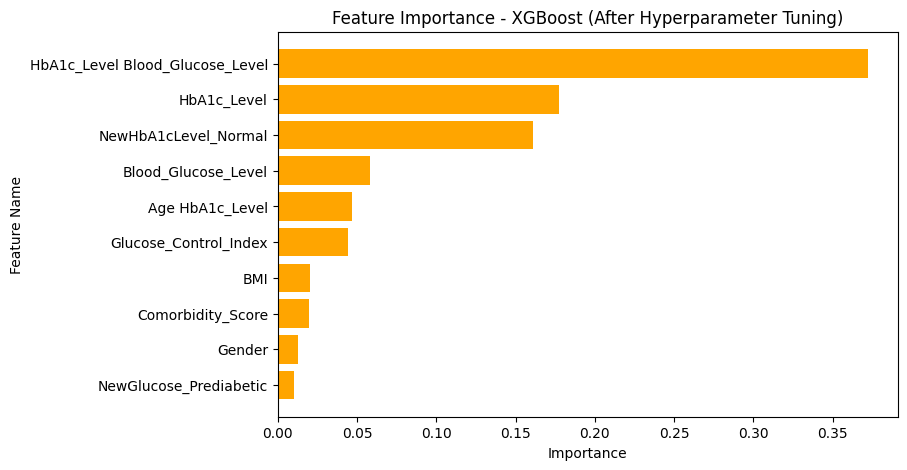

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Optimized Hybrid Model (XGBoost + SVM) Performance
Best XGBoost Hyperparameters: {'scale_pos_weight': np.float64(0.5), 'n_estimators': np.int64(400), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.1577777777777778)}
Best SVM Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': np.float64(2.1544346900318843)}
Test Accuracy: 96.4467%
Test Balanced Accuracy: 85.8924%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     13725
           1       0.83      0.73      0.78      1275

    accuracy                           0.96     15000
   macro avg       0.90      0.86      0.88     15000
weighted avg       0.96      0.96      0.96     15000



In [71]:
# ✅ Step 1: Define Randomized Hyperparameter Grid for XGBoost
param_dist_xgb = {
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "n_estimators": np.arange(100, 600, 100),
    "max_depth": np.arange(3, 10, 2),
    "scale_pos_weight": np.linspace(0.5, 1.5, 5)
}

# ✅ Step 2: Perform RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    XGBClassifier(objective="binary:logistic", use_label_encoder=False, eval_metric="logloss", random_state=42),
    param_distributions=param_dist_xgb, 
    n_iter=20,  # Number of random combinations to try
    scoring="accuracy", 
    cv=3, 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)
random_search_xgb.fit(X_train_balanced, y_train_balanced)

# ✅ Step 3: Train Best XGBoost Model
best_xgb = random_search_xgb.best_estimator_
y_train_xgb = best_xgb.predict_proba(X_train_balanced)[:, 1]
X_test_xgb = best_xgb.predict_proba(X_test)[:, 1].reshape(-1, 1)

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': best_xgb.feature_importances_})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print Top 10 Features
print("\nFeature Importance AFTER Hyperparameter Tuning - XGBoost")
print(feature_importance_df.head(10))  # Print Top 10 Features

# Plot Feature Importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='orange')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance - XGBoost (After Hyperparameter Tuning)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# ✅ Step 4: Standardize Features for SVM
scaler = StandardScaler()
y_train_xgb_scaled = scaler.fit_transform(y_train_xgb.reshape(-1, 1))
X_test_xgb_scaled = scaler.transform(X_test_xgb)

# ✅ Step 5: Define Randomized Hyperparameter Grid for SVM
param_dist_svm = {
    "C": np.logspace(-3, 2, 10),
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

# ✅ Step 6: Perform RandomizedSearchCV for SVM
random_search_svm = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    param_distributions=param_dist_svm, 
    n_iter=10,  
    scoring="accuracy", 
    cv=3, 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)
random_search_svm.fit(y_train_xgb_scaled, y_train_balanced)

# ✅ Step 7: Train Best SVM Model
best_svm = random_search_svm.best_estimator_
y_pred_hybrid_svm = best_svm.predict(X_test_xgb_scaled)

# ✅ Step 8: Compute Accuracy & Balanced Accuracy
test_accuracy_hybrid_svm = accuracy_score(y_test, y_pred_hybrid_svm) * 100
test_balanced_accuracy_hybrid_svm = balanced_accuracy_score(y_test, y_pred_hybrid_svm) * 100

# ✅ Step 9: Print Scores
print("\nOptimized Hybrid Model (XGBoost + SVM) Performance")
print(f"Best XGBoost Hyperparameters: {random_search_xgb.best_params_}")
print(f"Best SVM Hyperparameters: {random_search_svm.best_params_}")
print(f"Test Accuracy: {test_accuracy_hybrid_svm:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy_hybrid_svm:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_hybrid_svm))


### Hybrid (XGBoost + LR) using RandomizedSearchCV

Default (Before parameters)


Feature Importance BEFORE Hyperparameter Tuning - XGBoost
                            Feature  Importance
9   HbA1c_Level Blood_Glucose_Level    0.384632
8                       HbA1c_Level    0.116634
18             NewHbA1cLevel_Normal    0.111290
2                   Age HbA1c_Level    0.089669
4               Blood_Glucose_Level    0.063704
7             Glucose_Control_Index    0.059940
3                               BMI    0.022188
5                 Comorbidity_Score    0.020622
17           NewGlucose_Prediabetic    0.014321
6                            Gender    0.014301


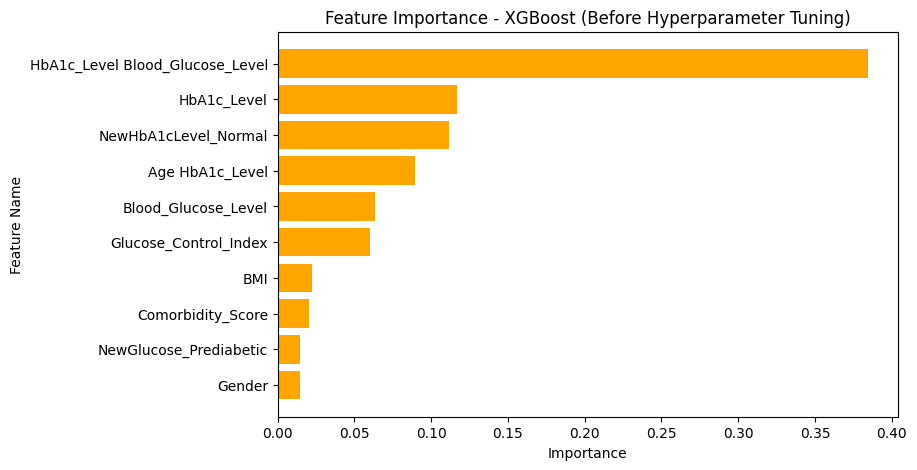


Default Hybrid Model (XGBoost + Logistic Regression) Performance
Test Accuracy: 95.7400%
Test Balanced Accuracy: 88.1742%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98     13725
           1       0.73      0.79      0.76      1275

    accuracy                           0.96     15000
   macro avg       0.86      0.88      0.87     15000
weighted avg       0.96      0.96      0.96     15000



In [72]:
# Train Default XGBoost Model
xgb_default = XGBClassifier(objective="binary:logistic", use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_default.fit(X_train_balanced, y_train_balanced)

y_train_xgb = xgb_default.predict_proba(X_train_balanced)[:, 1]
X_test_xgb = xgb_default.predict_proba(X_test)[:, 1].reshape(-1, 1)

# Feature Importance
feature_importance_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': xgb_default.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print Top 10 Features
print("\nFeature Importance BEFORE Hyperparameter Tuning - XGBoost")
print(feature_importance_df.head(10))

# Plot Feature Importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='orange')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance - XGBoost (Before Hyperparameter Tuning)')
plt.gca().invert_yaxis()
plt.show()

# Standardize Features for Logistic Regression
scaler = StandardScaler()
y_train_xgb_scaled = scaler.fit_transform(y_train_xgb.reshape(-1, 1))
X_test_xgb_scaled = scaler.transform(X_test_xgb)

# Train Default Logistic Regression Model
logreg_default = LogisticRegression(class_weight="balanced", random_state=42)
logreg_default.fit(y_train_xgb_scaled, y_train_balanced)

y_pred_hybrid_lr_default = logreg_default.predict(X_test_xgb_scaled)

# Compute Accuracy & Balanced Accuracy
test_accuracy_hybrid = accuracy_score(y_test, y_pred_hybrid_lr_default) * 100
test_balanced_accuracy_hybrid = balanced_accuracy_score(y_test, y_pred_hybrid_lr_default) * 100

# Print Scores
print("\nDefault Hybrid Model (XGBoost + Logistic Regression) Performance")
print(f"Test Accuracy: {test_accuracy_hybrid:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy_hybrid:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_hybrid_lr_default))


After parameters

In [67]:
# ✅ Step 1: Define Randomized Hyperparameter Grid for XGBoost
param_dist_xgb = {
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "n_estimators": np.arange(100, 600, 100),
    "max_depth": np.arange(3, 10, 2),
    "scale_pos_weight": np.linspace(0.5, 1.5, 5)
}

# ✅ Step 2: Perform RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    XGBClassifier(objective="binary:logistic", use_label_encoder=False, eval_metric="logloss", random_state=42),
    param_distributions=param_dist_xgb, 
    n_iter=20,  # Number of random combinations to try
    scoring="accuracy", 
    cv=3, 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)
random_search_xgb.fit(X_train_balanced, y_train_balanced)

# ✅ Step 3: Train Best XGBoost Model
best_xgb = random_search_xgb.best_estimator_
y_train_xgb = best_xgb.predict_proba(X_train_balanced)[:, 1]
X_test_xgb = best_xgb.predict_proba(X_test)[:, 1].reshape(-1, 1)

# ✅ Step 4: Standardize Features for Logistic Regression
scaler = StandardScaler()
y_train_xgb_scaled = scaler.fit_transform(y_train_xgb.reshape(-1, 1))
X_test_xgb_scaled = scaler.transform(X_test_xgb)

# ✅ Step 5: Define Randomized Hyperparameter Grid for Logistic Regression
param_dist_logreg = {
    "C": np.logspace(-3, 2, 10),
    "solver": ["liblinear", "lbfgs"]
}

# ✅ Step 6: Perform RandomizedSearchCV for Logistic Regression
random_search_logreg = RandomizedSearchCV(
    LogisticRegression(class_weight="balanced", random_state=42),
    param_distributions=param_dist_logreg, 
    n_iter=10,  
    scoring="accuracy", 
    cv=3, 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)
random_search_logreg.fit(y_train_xgb_scaled, y_train_balanced)

# ✅ Step 7: Train Best Logistic Regression Model
best_log_reg = random_search_logreg.best_estimator_
y_pred_hybrid_lr = best_log_reg.predict(X_test_xgb_scaled)

# ✅ Step 8: Compute Accuracy & Balanced Accuracy
test_accuracy_hybrid = accuracy_score(y_test, y_pred_hybrid_lr) * 100
test_balanced_accuracy_hybrid = balanced_accuracy_score(y_test, y_pred_hybrid_lr) * 100

# ✅ Step 9: Print Scores
print("\nOptimized Hybrid Model (XGBoost + Logistic Regression) Performance")
print(f"Best XGBoost Hyperparameters: {random_search_xgb.best_params_}")
print(f"Best Logistic Regression Hyperparameters: {random_search_logreg.best_params_}")
print(f"Test Accuracy: {test_accuracy_hybrid:.4f}%")
print(f"Test Balanced Accuracy: {test_balanced_accuracy_hybrid:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_hybrid_lr))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Optimized Hybrid Model (XGBoost + Logistic Regression) Performance
Best XGBoost Hyperparameters: {'scale_pos_weight': np.float64(0.5), 'n_estimators': np.int64(400), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.1577777777777778)}
Best Logistic Regression Hyperparameters: {'solver': 'liblinear', 'C': np.float64(0.001)}
Test Accuracy: 96.7600%
Test Balanced Accuracy: 85.0320%

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     13725
           1       0.89      0.71      0.79      1275

    accuracy                           0.97     15000
   macro avg       0.93      0.85      0.89     15000
weighted avg       0.97      0.97      0.97     15000



### Model Performance Summary

Before Parameters

In [76]:
# Define model names
model_names = [
    "Default LightGBM", 
    "Default XGBoost", 
    "Default Hybrid (XGBoost + SVM)", 
    "Default Hybrid (XGBoost + Logistic Regression)"
]

# Initialize lists for metrics
accuracy_values = []
balanced_accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Models and predictions dictionary
models_predictions = {
    "Default LightGBM": y_pred_lgbm_default,
    "Default XGBoost": y_pred_xgb_default,
    "Default Hybrid (XGBoost + SVM)": y_pred_hybrid_svm_default,
    "Default Hybrid (XGBoost + Logistic Regression)": y_pred_hybrid_lr_default
}

# Collect performance metrics for each model
for model, y_pred in models_predictions.items():
    accuracy_values.append(accuracy_score(y_test, y_pred))
    balanced_accuracy_values.append(balanced_accuracy_score(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    precision_values.append(report['weighted avg']['precision'])
    recall_values.append(report['weighted avg']['recall'])
    f1_values.append(report['weighted avg']['f1-score'])

# Create DataFrame
results_df = pd.DataFrame({
    "Model": model_names,
    "Test Accuracy": accuracy_values,
    "Balanced Accuracy": balanced_accuracy_values,
    "Precision": precision_values,
    "Recall": recall_values,
    "F1-Score": f1_values
})

# Print the table
print("\nDefault Model Performance Summary")
print(results_df.to_string(index=False))



Default Model Performance Summary
                                         Model  Test Accuracy  Balanced Accuracy  Precision   Recall  F1-Score
                              Default LightGBM       0.970933           0.837201   0.971018 0.970933  0.968513
                               Default XGBoost       0.970333           0.842921   0.969763 0.970333  0.968182
                Default Hybrid (XGBoost + SVM)       0.966133           0.864104   0.964768 0.966133  0.965153
Default Hybrid (XGBoost + Logistic Regression)       0.957400           0.881742   0.959150 0.957400  0.958161


After Parameters

In [69]:
# Define model names
model_names = [
    "Optimized LightGBM", 
    "Optimized XGBoost", 
    "Optimized Hybrid (XGBoost + SVM)", 
    "Optimized Hybrid (XGBoost + Logistic Regression)"
]

# Initialize lists for metrics
accuracy_values = []
balanced_accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Models and predictions dictionary
models_predictions = {
    "Optimized LightGBM": y_pred_lgbm_opt,
    "Optimized XGBoost": y_pred_xgb_opt,
    "Optimized Hybrid (XGBoost + SVM)": y_pred_hybrid_svm,
    "Optimized Hybrid (XGBoost + Logistic Regression)": y_pred_hybrid_lr
}

# Collect performance metrics for each model
for model, y_pred in models_predictions.items():
    accuracy_values.append(accuracy_score(y_test, y_pred))
    balanced_accuracy_values.append(balanced_accuracy_score(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    precision_values.append(report['weighted avg']['precision'])
    recall_values.append(report['weighted avg']['recall'])
    f1_values.append(report['weighted avg']['f1-score'])

# Create DataFrame
results_df = pd.DataFrame({
    "Model": model_names,
    "Test Accuracy": accuracy_values,
    "Balanced Accuracy": balanced_accuracy_values,
    "Precision": precision_values,
    "Recall": recall_values,
    "F1-Score": f1_values
})

# Print the table
print("\nOptimized Model Performance Summary")
print(results_df.to_string(index=False))



Optimized Model Performance Summary
                                           Model  Test Accuracy  Balanced Accuracy  Precision   Recall  F1-Score
                              Optimized LightGBM       0.968200           0.856696   0.966776 0.968200  0.966749
                               Optimized XGBoost       0.964200           0.854866   0.962612 0.964200  0.963039
                Optimized Hybrid (XGBoost + SVM)       0.964467           0.858924   0.963004 0.964467  0.963446
Optimized Hybrid (XGBoost + Logistic Regression)       0.967600           0.850320   0.966127 0.967600  0.965942


### ROC Curves & Confusion Matrix After Hypertuning


Confusion Matrix - Optimized XGBoost:
[[13553   172]
 [  354   921]]
False Positives (FP): 172
False Negatives (FN): 354

Optimized XGBoost - False Positives (First 5 samples):
       Blood_Glucose_Level  HbA1c_Level       BMI  Smoking_History_current  \
21553             0.000000          0.5  0.833333                      0.0   
11970             0.084746          0.5 -0.500000                      0.0   
24777             0.338983          0.5  0.000000                      0.0   
71415             0.322034          0.5  1.833333                      0.0   
40069             0.000000          0.5  1.833333                      0.0   

       Smoking_History_former  
21553                     1.0  
11970                     1.0  
24777                     0.0  
71415                     0.0  
40069                     0.0  

Optimized XGBoost - False Negatives (First 5 samples):
       Blood_Glucose_Level  HbA1c_Level       BMI  Smoking_History_current  \
38776             0.084746 

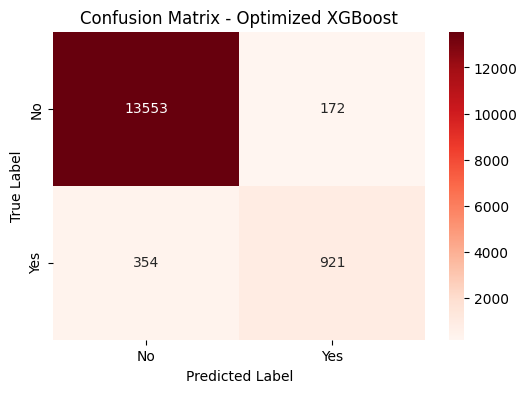


Confusion Matrix - Optimized LightGBM:
[[13582   143]
 [  347   928]]
False Positives (FP): 143
False Negatives (FN): 347

Optimized LightGBM - False Positives (First 5 samples):
       Blood_Glucose_Level  HbA1c_Level       BMI  Smoking_History_current  \
11970             0.084746          0.5 -0.500000                      0.0   
24777             0.338983          0.5  0.000000                      0.0   
71415             0.322034          0.5  1.833333                      0.0   
40069             0.000000          0.5  1.833333                      0.0   
54635             0.322034          0.5  1.833333                      0.0   

       Smoking_History_former  
11970                     1.0  
24777                     0.0  
71415                     0.0  
40069                     0.0  
54635                     0.0  

Optimized LightGBM - False Negatives (First 5 samples):
       Blood_Glucose_Level  HbA1c_Level       BMI  Smoking_History_current  \
38776             0.0847

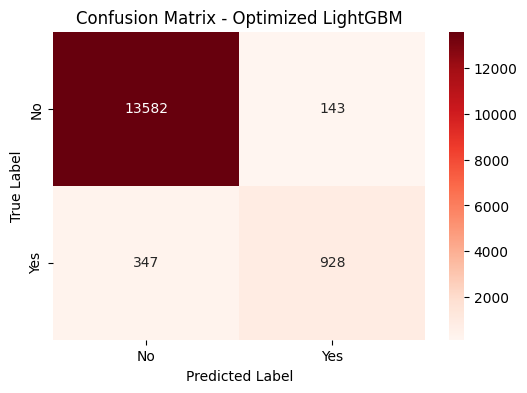


Confusion Matrix - Hybrid Model (XGBoost + SVM):
[[13514   211]
 [  328   947]]
False Positives (FP): 211
False Negatives (FN): 328

Hybrid Model (XGBoost + SVM) - False Positives (First 5 samples):
       Blood_Glucose_Level  HbA1c_Level       BMI  Smoking_History_current  \
70272             1.016949          0.5  0.000000                      0.0   
22270            -0.169492          0.5  0.666667                      0.0   
11970             0.084746          0.5 -0.500000                      0.0   
24777             0.338983          0.5  0.000000                      0.0   
71415             0.322034          0.5  1.833333                      0.0   

       Smoking_History_former  
70272                     1.0  
22270                     1.0  
11970                     1.0  
24777                     0.0  
71415                     0.0  

Hybrid Model (XGBoost + SVM) - False Negatives (First 5 samples):
       Blood_Glucose_Level  HbA1c_Level       BMI  Smoking_History_curre

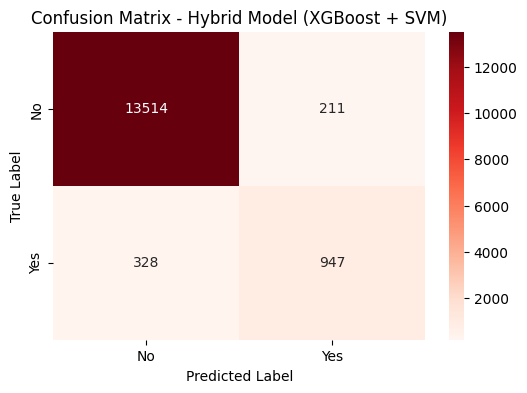


Confusion Matrix - Hybrid Model (XGBoost + Logistic Regression):
[[13613   112]
 [  370   905]]
False Positives (FP): 112
False Negatives (FN): 370

Hybrid Model (XGBoost + Logistic Regression) - False Positives (First 5 samples):
       Blood_Glucose_Level  HbA1c_Level       BMI  Smoking_History_current  \
70272             1.016949          0.5  0.000000                      0.0   
22270            -0.169492          0.5  0.666667                      0.0   
11970             0.084746          0.5 -0.500000                      0.0   
24777             0.338983          0.5  0.000000                      0.0   
71415             0.322034          0.5  1.833333                      0.0   

       Smoking_History_former  
70272                     1.0  
22270                     1.0  
11970                     1.0  
24777                     0.0  
71415                     0.0  

Hybrid Model (XGBoost + Logistic Regression) - False Negatives (First 5 samples):
       Blood_Glucose_Lev

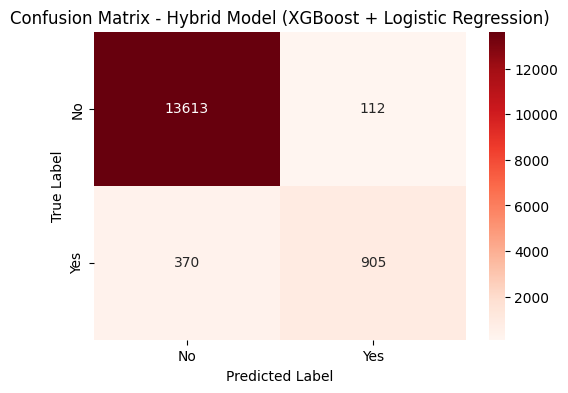

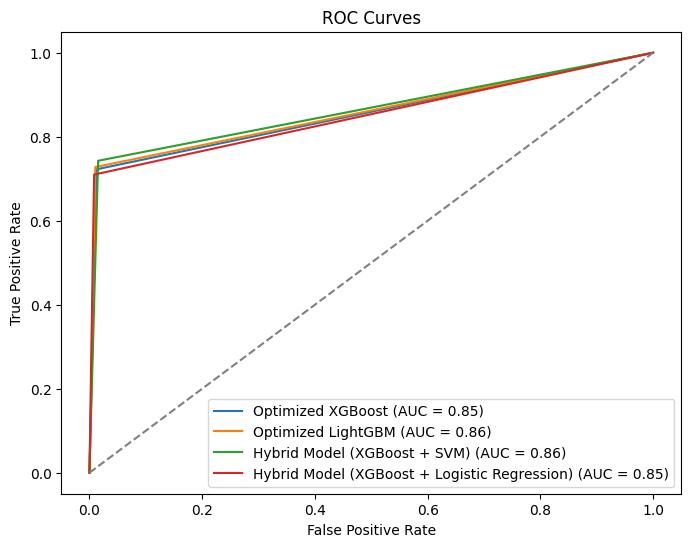

In [41]:
### ✅ Define Model Predictions Dictionary
models = {
    "Optimized XGBoost": y_pred_xgb_opt,
    "Optimized LightGBM": y_pred_lgbm_opt,
    # "Logistic Regression": y_pred_log_reg,
    "Hybrid Model (XGBoost + SVM)": y_pred_hybrid_svm,
    "Hybrid Model (XGBoost + Logistic Regression)": y_pred_hybrid_lr
}

# ✅ Selecting only important features for better readability
important_features = ['Blood_Glucose_Level', 'HbA1c_Level', 'BMI', 'Smoking_History_current', 'Smoking_History_former']

### ✅ Confusion Matrices
for model_name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)

    # Extract values for False Positives (FP) and False Negatives (FN)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nConfusion Matrix - {model_name}:")
    print(cm)
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")

    # Identify misclassified samples
    false_positives = X_test[(y_test == 0) & (y_pred == 1)]  # Predicted 1 but actual is 0
    false_negatives = X_test[(y_test == 1) & (y_pred == 0)]  # Predicted 0 but actual is 1

    # Identify correctly classified samples for comparison
    correct_negatives = X_test[(y_test == 0) & (y_pred == 0)]  # Correct non-diabetic
    correct_positives = X_test[(y_test == 1) & (y_pred == 1)]  # Correct diabetic

    # ✅ Print first few False Positives & False Negatives
    print(f"\n{model_name} - False Positives (First 5 samples):")
    print(false_positives[important_features].head())

    print(f"\n{model_name} - False Negatives (First 5 samples):")
    print(false_negatives[important_features].head())

    # ✅ Compare Statistics Between Misclassified & Correctly Classified Samples
    fp_summary = false_positives[important_features].describe()
    fn_summary = false_negatives[important_features].describe()
    correct_neg_summary = correct_negatives[important_features].describe()
    correct_pos_summary = correct_positives[important_features].describe()

    # ✅ Visualizing the Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

### ✅ ROC Curves
plt.figure(figsize=(8, 6))
for model_name, y_pred in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

In [42]:
print("\nPossible Reasons for False Positives (FP):")
print("- FP cases may have high glucose or HbA1c but are not diabetic.")
print("- Former smokers may be influencing predictions.")
print("- The model may be over-sensitive to high BMI.")

print("\nPossible Reasons for False Negatives (FN):")
print("- FN cases may have lower glucose but are still diabetic.")
print("- The model may miss borderline diabetic cases.")
print("- Patients with good HbA1c control may be misclassified.")


Possible Reasons for False Positives (FP):
- FP cases may have high glucose or HbA1c but are not diabetic.
- Former smokers may be influencing predictions.
- The model may be over-sensitive to high BMI.

Possible Reasons for False Negatives (FN):
- FN cases may have lower glucose but are still diabetic.
- The model may miss borderline diabetic cases.
- Patients with good HbA1c control may be misclassified.


# delete this if this is not used Base Models

In [43]:
# # Validation scores of all base models
# models = []
# models.append(('LR', LogisticRegression(random_state = 12345)))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier(random_state = 12345)))
# models.append(('RF', RandomForestClassifier(random_state = 12345)))
# models.append(('SVM', SVC(gamma='auto', random_state = 12345)))
# models.append(('XGB', GradientBoostingClassifier(random_state = 12345)))
# # models.append(("LightGBM", LGBMClassifier(random_state = 12345)))

# # Cross-validation setup (10-fold CV on training data)
# kfold = KFold(n_splits=10, shuffle=True, random_state=12345)
# # evaluate each model in turn
# smote_train_results = []
# test_results = []
# results = []
# names = []

### 6) Model Tuning

### 1.1) Final Model Installation

In [44]:
# rf_tuned = RandomForestClassifier(**gs_cv.best_params_)
# rf_tuned = rf_tuned.fit(X,y)
# cross_val_score(rf_tuned, X, y, cv = 10).mean()

In [45]:
# feature_imp = pd.Series(rf_tuned.feature_importances_,
#                         index=X.columns).sort_values(ascending=False)

# sns.barplot(x=feature_imp, y=feature_imp.index)
# plt.xlabel('Significance Score Of Variables')
# plt.ylabel('Variables')
# plt.title("Variable Severity Levels")
# plt.show()

### 2) XGBoost Tuning

In [46]:
# xgb = GradientBoostingClassifier(random_state = 12345)

In [47]:
# xgb_params = {
#     "learning_rate": [0.01, 0.1, 0.2, 1],
#     "min_samples_split": np.linspace(0.1, 0.5, 10),
#     "max_depth":[3,5,8],
#     "subsample":[0.5, 0.9, 1.0],
#     "n_estimators": [100,1000]}

In [48]:
# xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X, y)

In [49]:
# xgb_cv_model.best_params_

### Final Model Installation

In [50]:
# xgb_tuned = GradientBoostingClassifier(**xgb_cv_model.best_params_).fit(X,y)

In [51]:
# cross_val_score(xgb_tuned, X, y, cv = 10).mean()

In [52]:
# feature_imp = pd.Series(xgb_tuned.feature_importances_,
#                         index=X.columns).sort_values(ascending=False)

# sns.barplot(x=feature_imp, y=feature_imp.index)
# plt.xlabel('Significance Score Of Variables')
# plt.ylabel('Variables')
# plt.title("Variable Severity Levels")
# plt.show()

### Comparison of Final Models

In [53]:
# models = []

# models.append(('RF', RandomForestClassifier(random_state = 12345, max_depth = 8, max_features = 7, min_samples_split = 2, n_estimators = 500)))
# models.append(('XGB', GradientBoostingClassifier(random_state = 12345, learning_rate = 0.1, max_depth = 5, min_samples_split = 0.1, n_estimators = 100, subsample = 1.0)))

# # evaluate each model in turn
# results = []
# names = []

In [54]:
# for name, model in models:
    
#         kfold = KFold(n_splits = 10, random_state = 12345)
#         cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
#         results.append(cv_results)
#         names.append(name)
#         msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#         print(msg)
        
# # boxplot algorithm comparison
# fig = plt.figure(figsize=(15,10))
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()

# 7) Reporting

The aim of this study was to create classification models for the diabetes data set and to predict whether a person is sick by establishing models and to obtain maximum validation scores in the established models. The work done is as follows:

1) Diabetes Data Set read.

2) With Exploratory Data Analysis; The data set's structural data were checked.
The types of variables in the dataset were examined. Size information of the dataset was accessed. The 0 values in the data set are missing values. Primarily these 0 values were replaced with NaN values. Descriptive statistics of the data set were examined.

3) Data Preprocessing section;
df for: The NaN values missing observations were filled with the median values of whether each variable was sick or not. The outliers were determined by LOF and dropped. The X variables were standardized with the rubost method..

4) During Model Building;
Logistic Regression, KNN, SVM, CART, Random Forests, XGBoost, LightGBM like using machine learning models Cross Validation Score were calculated. Later Random Forests, XGBoost, LightGBM hyperparameter optimizations optimized to increase Cross Validation value.

5) Result;
The model created as a result of XGBoost hyperparameter optimization became the model with the lowest Cross Validation Score value. (0.90)